# Regression Residual Backtest

This will be a full-sample in-sample trading the residuals of the OLS model

## Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\TreasuryInflationPCA\root\src")
from PCSpreadOLS import PCASpreadOLS

## Generate Signal Return

In [3]:
def _lag_resid(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(lag_resid = lambda x: x.resid.shift()).
        dropna())
    
    return df_out

def get_resid_rtn() -> pd.DataFrame: 

    df_out = (PCASpreadOLS().get_signal_ols().assign(
        resid     = lambda x: (x.beta * x.lag_spread) + x.alpha,
        group_var = lambda x: x.variable + " " + x.security + " " + x.input_val).
        groupby("group_var").
        apply(_lag_resid).
        reset_index(drop = True).
        assign(signal_bps = lambda x: np.sign(x.lag_resid) * x.PX_bps).
        drop(columns = ["group_var"]))
    
    return df_out

df_resid = get_resid_rtn()

## Signal Return and Sharpe

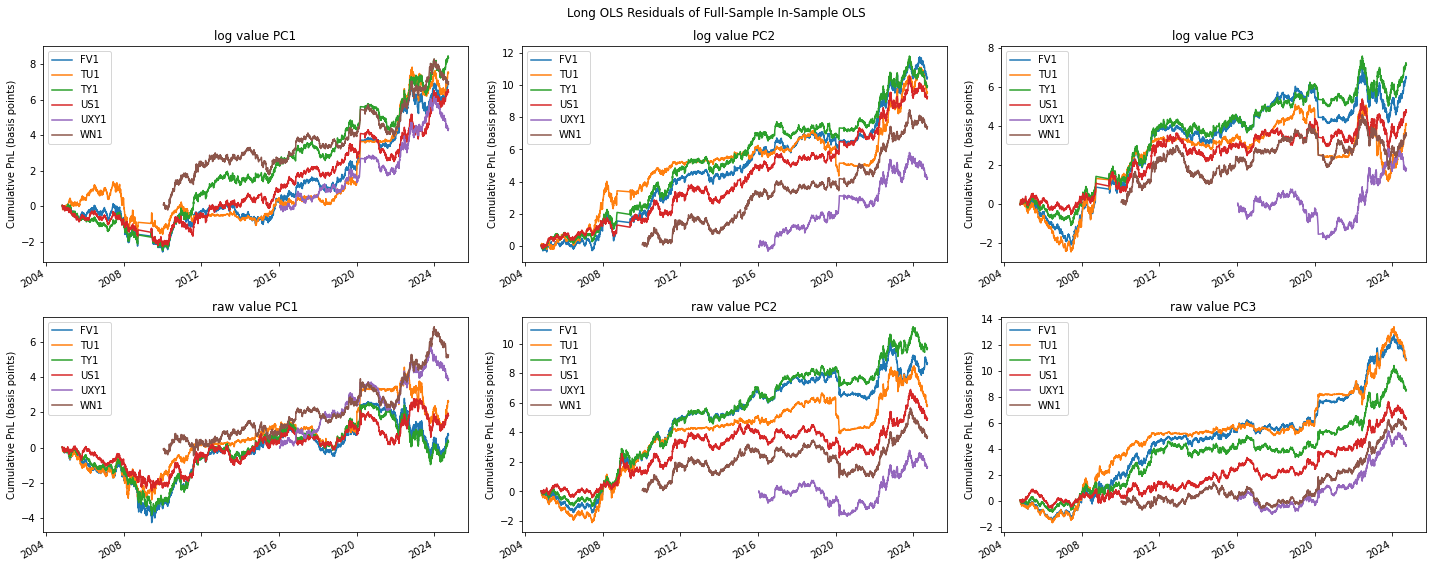

In [4]:
def plot_resid_rtn(df_resid: pd.DataFrame) -> plt.Figure: 
    
    df_tmp = (df_resid.assign(
        group_var = lambda x: x.input_val.str.replace("_", " ") + " "+ x.variable))

    group_vars = df_tmp.sort_values(["variable", "input_val"]).group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (20,8))

    for group_var, ax in zip(group_vars, axes.flatten()): 

        (df_tmp.query(
            "group_var == @group_var").
            rename(columns = {"security": ""}).
            pivot(index = "date", columns = "", values = "signal_bps").
            cumsum().
            plot(
                ax     = ax,
                title  = group_var,
                xlabel = "",
                ylabel = "Cumulative PnL (basis points)"))

    fig.suptitle("Long OLS Residuals of Full-Sample In-Sample OLS")
    plt.tight_layout()
    
plot_resid_rtn(df_resid)

In [5]:
def get_signal_shapre(df_resid: pd.DataFrame) -> pd.DataFrame: 
    
    df_sharpe = (df_resid[
        ["input_val", "variable", "security", "signal_bps"]].
        groupby(["input_val", "variable", "security"]).
        agg(["mean", "std"])
        ["signal_bps"].
        reset_index().
        rename(columns = {
            "mean": "mean_rtn", 
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)))
    
    return df_sharpe

df_signal_sharpe = get_signal_shapre(df_resid)

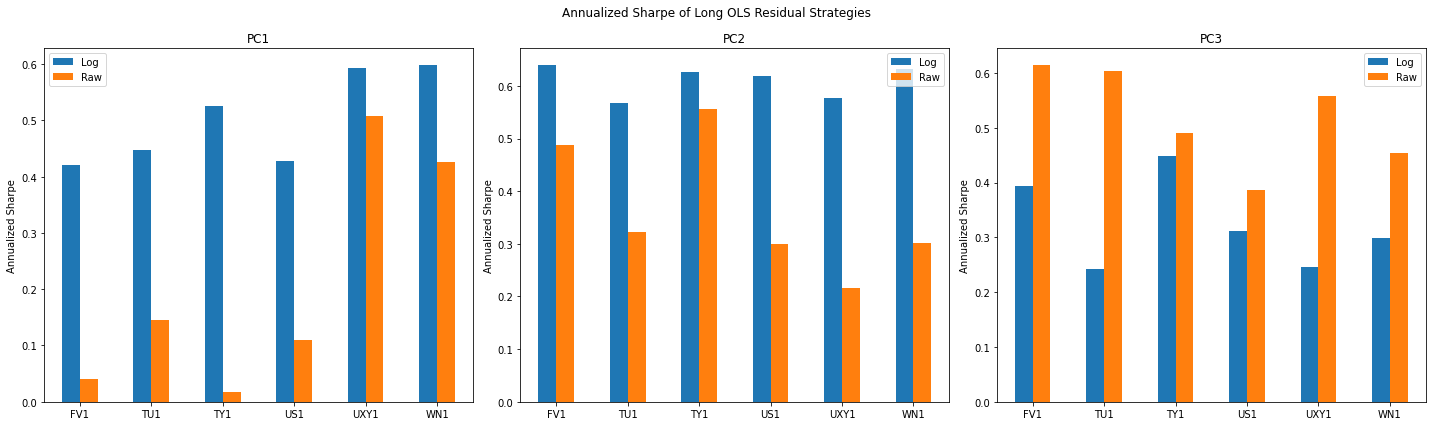

In [6]:
def plot_signal_sharpe(df_signal_sharpe: pd.DataFrame) -> plt.Figure: 
    
    pcs = df_signal_sharpe.variable.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(pcs), figsize = (20,6))

    for pc, ax in zip(pcs, axes.flatten()): 

        (df_signal_sharpe.query(
            "variable == @pc").
            assign(input_val = lambda x: x.input_val.str.split("_").str[0].str.capitalize()).
            rename(columns = {"input_val": ""}).
            pivot(index = "security", columns = "", values = "sharpe").
            plot(
                kind   = "bar",
                ax     = ax,
                title  = pc,
                ylabel = "Annualized Sharpe",
                rot    = 0,
                xlabel = ""))

    fig.suptitle("Annualized Sharpe of Long OLS Residual Strategies")
    plt.tight_layout()
    
plot_signal_sharpe(df_signal_sharpe)

## Portfolio Return & Sharpe

In [7]:
def _get_erc(df: pd.DataFrame, window: int) -> pd.DataFrame: 
    
    df_inv = (df.pivot(
        index = "date", columns = "security", values = "signal_bps").
        ewm(span = window, adjust = False).
        std().
        shift().
        apply(lambda x: 1 / x).
        reset_index().
        melt(id_vars = "date").
        dropna().
        rename(columns = {"value": "inv_vol"}))
    
    df_out = (df_inv.drop(
        columns = ["security"]).
        groupby("date").
        agg("sum").
        rename(columns = {"inv_vol": "cum_vol"}).
        merge(right = df_inv, how = "inner", on = ["date"]).
        merge(right = df[["date", "security", "signal_bps"]], how = "inner", on = ["date", "security"]).
        assign(weighted_bps = lambda x: x.inv_vol / x.cum_vol * x.signal_bps)
        [["date", "weighted_bps"]].
        groupby("date").
        agg("sum"))
    
    return df_out
 

def get_port(df_resid: pd.DataFrame, window: int = 30) -> pd.DataFrame: 

    df_mean_port = (df_resid[
        ["date", "input_val", "variable", "signal_bps"]].
        groupby(["date", "input_val", "variable"]).
        agg("mean").
        reset_index().
        rename(columns = {"signal_bps": "mean_port"}))

    df_port = (df_resid.assign(
        group_var = lambda x: x.input_val + " " + x.variable).
        groupby("group_var").
        apply(_get_erc, window).
        reset_index().
        assign(
            input_val = lambda x: x.group_var.str.split(" ").str[0],
            variable  = lambda x: x.group_var.str.split(" ").str[1]).
        drop(columns = ["group_var"]).
        rename(columns = {"weighted_bps": "erc_port"}).
        merge(right = df_mean_port, how = "inner", on = ["date", "input_val", "variable"]))
    
    return df_port

df_port = get_port(df_resid)

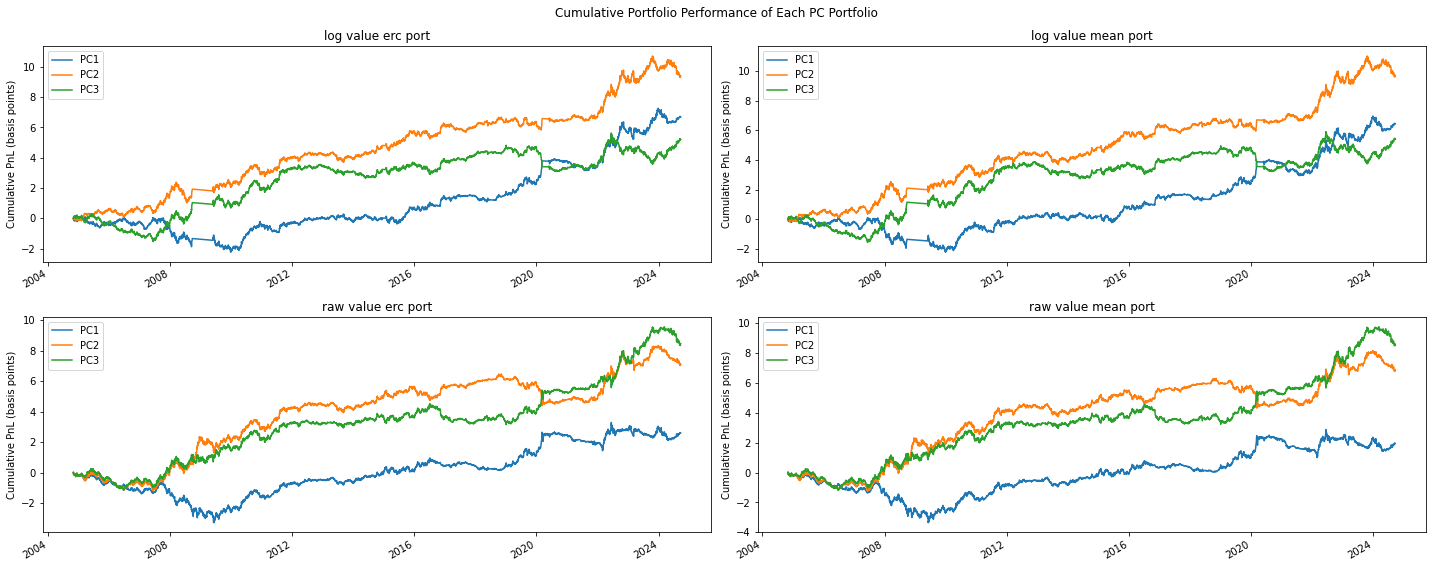

In [8]:
def plot_cumulative_port(df_port: pd.DataFrame) -> plt.Figure: 

    df_longer = (df_port.rename(
        columns = {"variable": "pc"}).
        melt(id_vars = ["date", "input_val", "pc"]).
        assign(group_var = lambda x: x.input_val + " " + x.variable))
    
    group_vars = df_longer.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 2, figsize = (20,8))

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df_longer.query(
            "group_var == @group_var").
            rename(columns = {"pc": ""}).
            pivot(index = "date", columns = "", values = "value").
            cumsum().
            plot(
                ax     = ax,
                xlabel = "",
                title  = group_var.replace("_", " "),
                ylabel = "Cumulative PnL (basis points)"))

    fig.suptitle("Cumulative Portfolio Performance of Each PC Portfolio")
    plt.tight_layout()
    
plot_cumulative_port(df_port)

In [9]:
def get_port_sharpe(df_port: pd.DataFrame) -> pd.DataFrame: 
    
    df_longer = (df_port.rename(
        columns = {"variable": "pc"}).
        melt(id_vars = ["date", "input_val", "pc"]).
        assign(group_var = lambda x: x.input_val + " " + x.variable))
    
    df_sharpe = (df_longer[
        ["input_val", "pc", "variable", "value"]].
        groupby(["input_val", "pc", "variable"]).
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_sharpe

df_port_sharpe = get_port_sharpe(df_port)

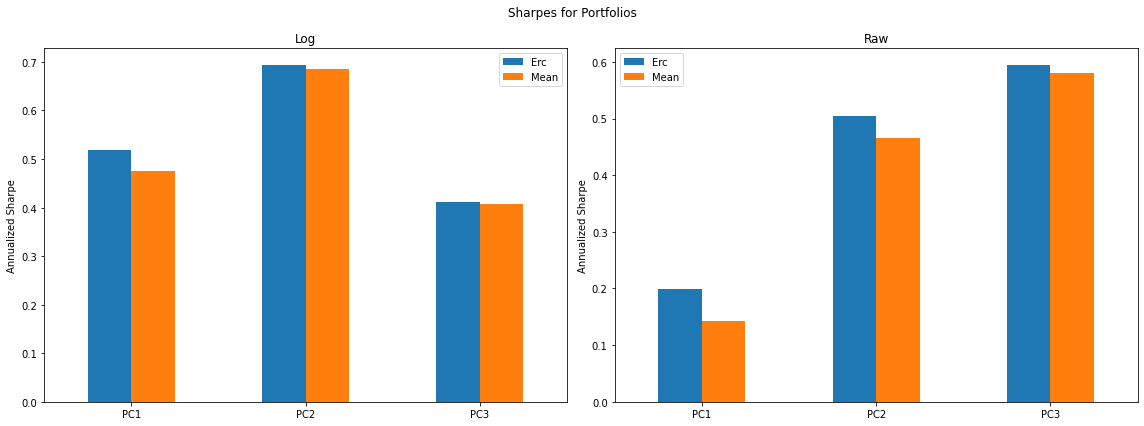

In [10]:
def plot_port_sharpe(df_port_sharpe: pd.DataFrame) -> plt.Figure:
    
    df_tmp = (df_port_sharpe.assign(
        input_val = lambda x: x.input_val.str.split("_").str[0].str.capitalize(),
        variable  = lambda x: x.variable.str.split("_").str[0].str.capitalize()).
        rename(columns = {"variable": ""}).
        pivot(index = ["input_val", "pc"], columns = "", values = "sharpe").
        reset_index())

    variables = df_tmp.input_val.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (16,6))

    for variable, ax in zip(variables, axes.flatten()):

        (df_tmp.query(
            "input_val == @variable").
            set_index("pc").
            plot(
                ax     =  ax,
                kind   = "bar",
                xlabel = "",
                rot    = 0,
                ylabel = "Annualized Sharpe",
                title  = variable))

    fig.suptitle("Sharpes for Portfolios")
    plt.tight_layout()
    
plot_port_sharpe(df_port_sharpe)